# Binary classification of commutative diagrams
## 1. Data pipeline

In [1]:
import pandas as pd
import numpy as np
#import torch
import os
import shutil
import random
import math
import tensorflow as tf
keras = tf.keras
import tensorflow_addons as tfa # Needed for Yogi optimizer
tfa.register_all(custom_kernels=False) # Registers TFA objects in TF dictionaries
import matplotlib.pyplot as plt

### 1.1 Expand working directory with folders for training images

In [2]:
##
unsortedSamplesDirName = 'png-2021-all_contexts'
##

cwd = os.getcwd()

unsortedSamplesDir = os.path.join(cwd, unsortedSamplesDirName)
assert('positive' in os.listdir(unsortedSamplesDir) and 'negative' in os.listdir(unsortedSamplesDir))
unsortedPositiveSamplesDir = os.path.join(unsortedSamplesDir, 'positive')
unsortedNegativeSamplesDir = os.path.join(unsortedSamplesDir, 'negative')

sortedSamplesDir = os.path.join(cwd, 'sortedSamples')
os.makedirs(sortedSamplesDir, exist_ok=True)

trainDir = os.path.join(sortedSamplesDir, 'train')
testDir = os.path.join(sortedSamplesDir, 'test')
valDir = os.path.join(sortedSamplesDir, 'val')
os.makedirs(trainDir, exist_ok=True)
os.makedirs(testDir, exist_ok=True)
os.makedirs(valDir, exist_ok=True)

trainPositiveDir = os.path.join(trainDir, 'positive')
trainNegativeDir = os.path.join(trainDir, 'negative')
testPositiveDir = os.path.join(testDir, 'positive')
testNegativeDir = os.path.join(testDir, 'negative')
valPositiveDir = os.path.join(valDir, 'positive')
valNegativeDir = os.path.join(valDir, 'negative')
os.makedirs(trainPositiveDir, exist_ok=True)
os.makedirs(trainNegativeDir, exist_ok=True)
os.makedirs(testPositiveDir, exist_ok=True)
os.makedirs(testNegativeDir, exist_ok=True)
os.makedirs(valPositiveDir, exist_ok=True)
os.makedirs(valNegativeDir, exist_ok=True)

### 1.2 Copy images into train, test and validation folders
The code currently randomly truncates the greater partition between positive and negative to achieve parity.

In [3]:
##
trainRatio = 0.6
testRatio = 0.2
valRatio = 0.2
assert(trainRatio + testRatio + valRatio == 1.)

positiveRatio = 0.5 # Desired ratio of positive samples in the sorted data

performCopy = False
##

if performCopy:
    positiveSamplesFilenameList = os.listdir(unsortedPositiveSamplesDir)
    negativeSamplesFilenameList = os.listdir(unsortedNegativeSamplesDir)
    random.shuffle(positiveSamplesFilenameList)
    random.shuffle(negativeSamplesFilenameList)
    numPositiveSamples = len(positiveSamplesFilenameList)
    numNegativeSamples = len(negativeSamplesFilenameList)

    if numPositiveSamples > numNegativeSamples:
        positiveSamplesFilenameList = positiveSamplesFilenameList[:numNegativeSamples]
        numPositiveSamples = len(positiveSamplesFilenameList)
    elif numNegativeSamples > numPositiveSamples:
        negativeSamplesFilenameList = negativeSamplesFilenameList[:numPositiveSamples]
        numNegativeSamples = len(negativeSamplesFilenameList)
    assert(numPositiveSamples == numNegativeSamples)

    numSamples = numPositiveSamples + numNegativeSamples

    numTrainSamples = math.floor(numSamples*trainRatio)
    numTestSamples = math.floor(numSamples*testRatio)
    numValSamples = math.floor(numSamples*valRatio)


    unsortedSamplesInfo = {'posDir':unsortedPositiveSamplesDir, 'negDir':unsortedNegativeSamplesDir, 'posFilenameList':positiveSamplesFilenameList,
                           'negFilenameList':negativeSamplesFilenameList}

    trainCopyInfo = {'num':numTrainSamples, 'posDir':trainPositiveDir, 'negDir':trainNegativeDir}
    testCopyInfo = {'num':numTestSamples, 'posDir':testPositiveDir, 'negDir':testNegativeDir}
    valCopyInfo = {'num':numValSamples, 'posDir':valPositiveDir, 'negDir':valNegativeDir}

    def copyImagesInPartition(unsortedSamplesInfo:dict, partitionCopyInfo:dict):
        for _ in range(math.floor(partitionCopyInfo['num']*positiveRatio)):
            copyImage(unsortedSamplesInfo['posFilenameList'], unsortedSamplesInfo['posDir'], partitionCopyInfo['posDir'])
        for _ in range(math.floor(partitionCopyInfo['num']*(1. - positiveRatio))):
            copyImage(unsortedSamplesInfo['negFilenameList'], unsortedSamplesInfo['negDir'], partitionCopyInfo['negDir'])

    def copyImage(sampleFilenameList, srcDir, dstDir):
        filename = sampleFilenameList.pop()
        src = os.path.join(srcDir, filename)
        dst = os.path.join(dstDir, filename)
        try:
            shutil.copyfile(src, dst)
        except PermissionError: # Ignores straggler files such as notebook checkpoints
            pass

    sampleDirectorySizes = [len(directory) for directory in [
        os.listdir(trainPositiveDir), os.listdir(trainNegativeDir), os.listdir(testPositiveDir), os.listdir(testNegativeDir),
        os.listdir(testPositiveDir), os.listdir(testNegativeDir)]]

    if all(size == 0 for size in sampleDirectorySizes):
        copyImagesInPartition(unsortedSamplesInfo, trainCopyInfo)
        copyImagesInPartition(unsortedSamplesInfo, testCopyInfo)
        copyImagesInPartition(unsortedSamplesInfo, valCopyInfo)
    else:
        raise Exception("Sorted image directories are not empty.")

[*Optional*]: Test whether a sample handful of the images were copied to the correct folders

In [4]:
##
runImageCopyTest = False

comparisonSampleSize = 50
imageFiletype = 'png'
##

if runImageCopyTest and performCopy:
    # These must be redefined here since they were popped
    positiveSamplesFilenameList = os.listdir(unsortedPositiveSamplesDir)
    negativeSamplesFilenameList = os.listdir(unsortedNegativeSamplesDir)

    sortedTrainPositiveFilenameList = os.listdir(trainPositiveDir)
    sortedTrainNegativeFilenameList = os.listdir(trainNegativeDir)
    sortedTestPositiveFilenameList = os.listdir(testPositiveDir)
    sortedTestNegativeFilenameList = os.listdir(testNegativeDir)
    sortedValPositiveFilenameList = os.listdir(valPositiveDir)
    sortedValNegativeFilenameList = os.listdir(valNegativeDir)
    random.shuffle(sortedTrainPositiveFilenameList)
    random.shuffle(sortedTrainNegativeFilenameList)
    random.shuffle(sortedTestPositiveFilenameList)
    random.shuffle(sortedTestNegativeFilenameList)
    random.shuffle(sortedValPositiveFilenameList)
    random.shuffle(sortedValNegativeFilenameList)

    allPositiveFilenameLists = [sortedTrainPositiveFilenameList, sortedTestPositiveFilenameList, sortedValPositiveFilenameList]
    allNegativeFilenameLists = [sortedTrainNegativeFilenameList, sortedTestNegativeFilenameList, sortedValNegativeFilenameList]

    def matchesImageFiletype(sampleFilename : str, imageFiletype : str): # Needed to ignore straggler files such as notebook checkpoints
        return sampleFilename[:len(imageFiletype)] == imageFiletype

    for fList in allPositiveFilenameLists:
        assert(all(sampleFilename in positiveSamplesFilenameList
                   for sampleFilename in fList[:comparisonSampleSize]
                   if matchesImageFiletype(sampleFilename, imageFiletype)))
    for fList in allNegativeFilenameLists:
        assert(all(sampleFilename in negativeSamplesFilenameList
                   for sampleFilename in fList[:comparisonSampleSize]
                   if matchesImageFiletype(sampleFilename, imageFiletype)))
    print('Test was succesful!')

### 1.3 Data generators

The data generators themselves can rescale the input pixel values to the [0, 1] range. Note that the pretrained baseline models expect certain kinds of input - Respectively, EfficientNet excepts pixel floats in the [0-255] range to be passed through the keras.applications.resnet_v2.preprocess_input() function, and ResNet expects its input to be raw, which will have its pixel values rescaled to the (-1, 1) range. Thus, a seperate set of data generators are made for them which do net rescale their input.

In [5]:
##
batchSize = 75
##

trainDataGeneratorFactory = keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
testDataGeneratorFactory = keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
valDataGenerator = keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

trainDataGenerator = trainDataGeneratorFactory.flow_from_directory( # Batch generator
    trainDir,
    target_size = (150, 150), # TODO: What size do I want?
    batch_size = batchSize,
    class_mode = 'binary')
testDataGenerator = testDataGeneratorFactory.flow_from_directory(
    testDir,
    target_size = (150, 150),
    batch_size = batchSize,
    class_mode = 'binary')
valDataGenerator = testDataGeneratorFactory.flow_from_directory(
    valDir,
    target_size = (150, 150),
    batch_size = batchSize,
    class_mode = 'binary')

baselineTrainDataGeneratorFactory = keras.preprocessing.image.ImageDataGenerator()
baselineTestDataGeneratorFactory = keras.preprocessing.image.ImageDataGenerator()
baselineValDataGeneratorFactory = keras.preprocessing.image.ImageDataGenerator()

baselineTrainDataGenerator = baselineTrainDataGeneratorFactory.flow_from_directory( # Batch generator
    trainDir,
    target_size = (150, 150), # TODO: What size do I want?
    batch_size = batchSize,
    class_mode = 'binary')
baselineTestDataGenerator = baselineTestDataGeneratorFactory.flow_from_directory(
    testDir,
    target_size = (150, 150),
    batch_size = batchSize,
    class_mode = 'binary')
baselineValDataGenerator = baselineValDataGeneratorFactory.flow_from_directory(
    valDir,
    target_size = (150, 150),
    batch_size = batchSize,
    class_mode = 'binary')

Found 2121 images belonging to 2 classes.
Found 706 images belonging to 2 classes.
Found 724 images belonging to 2 classes.
Found 2121 images belonging to 2 classes.
Found 706 images belonging to 2 classes.
Found 724 images belonging to 2 classes.


## 2 Baseline model implementation
Two pretrained models, EfficientNet and ResNet, will be implemented and tested as baselines. They will be implemented both as feature extractors (i.e. outputting their feature maps for a seperate model) and with retrained top-layer classifiers.

### 2.1 Implementation of untuned but pretrained EfficientNet and ResNet

In [6]:
# OTHER IDEA: Try a baseline model trained on MNIST

efficientNetB0Base = keras.applications.efficientnet.EfficientNetB0(
    include_top = False,
    input_shape = (150, 150, 3), # Input to pretrained model must have 3 channels
    weights = 'imagenet')
    #pooling = 'avg')
resNet50V2Base = keras.applications.resnet_v2.ResNet50V2(
    include_top = False,
    input_shape = (150, 150, 3), # Input to pretrained model must have 3 channels
    weights = 'imagenet')
    #pooling = 'avg')

efficientNetB0Base.trainable = False
resNet50V2Base.trainable = False

#efficientNetB0 = models.Sequential(name = 'efficientNetB0')
#efficientNetB0.add(tf.keras.layers.Conv2D(16, 7, strides = 3, padding = 'same'/'valid', activation="relu", trainable=True))

# keras.applications.resnet_v2.preprocess_input()
# When exactly should this be implemented?

### 2.2 Feature extraction function

In [7]:
def extractFeatures(model, generator, modelOutputShape:tuple, numSamples=None):
    if not numSamples:
        numSamples = generator.n
    if numSamples % batchSize != 0:
        numSamples -= (numSamples % batchSize)
    features = np.zeros(shape=(numSamples, *modelOutputShape))
    labels = np.zeros(shape=(numSamples))
    i = 0
    for inputBatch, labelBatch in generator:
        featureBatch = model.predict(inputBatch)
        features[i*batchSize : (i + 1)*batchSize] = featureBatch
        labels[i*batchSize : (i + 1)*batchSize] = labelBatch
        i += 1
        if i*batchSize >= numSamples:
            break
    return features, labels

### 2.3 EfficientNet as feature extraction

In [8]:
efficientNetBaseCanonicalOutputShape = (5, 5, 1280)
efficientNetBaseCanonicalFlatOutputShape = np.product(efficientNetBaseCanonicalOutputShape)

efficientNetTrainFeatures, efficientNetTrainLabels = extractFeatures(efficientNetB0Base, baselineTrainDataGenerator, efficientNetBaseCanonicalOutputShape)
efficientNetTestFeatures, efficientNetTestLabels = extractFeatures(efficientNetB0Base, baselineTestDataGenerator, efficientNetBaseCanonicalOutputShape)
efficientNetValFeatures, efficientNetValLabels = extractFeatures(efficientNetB0Base, baselineValDataGenerator, efficientNetBaseCanonicalOutputShape)

efficientNetTrainFeatures = np.reshape(efficientNetTrainFeatures, (efficientNetTrainFeatures.shape[0], efficientNetBaseCanonicalFlatOutputShape))
efficientNetTestFeatures = np.reshape(efficientNetTestFeatures, (efficientNetTestFeatures.shape[0], efficientNetBaseCanonicalFlatOutputShape))
efficientNetValFeatures = np.reshape(efficientNetValFeatures, (efficientNetValFeatures.shape[0], efficientNetBaseCanonicalFlatOutputShape))

flattenedFeatureShape = efficientNetTrainFeatures.shape

In [12]:
##
metrics = [keras.metrics.BinaryAccuracy(), keras.metrics.BinaryCrossentropy(), keras.metrics.AUC(), keras.metrics.Precision(), keras.metrics.Recall()]
metricNames = ['binary accuracy', 'binary cross entropy', 'AUC', 'precision', 'recall']

epochs = 30
##

efficientNetB0FEClassifier = keras.models.Sequential()
efficientNetB0FEClassifier.add(keras.layers.Dense(256, activation='relu', input_dim=efficientNetBaseCanonicalFlatOutputShape))
efficientNetB0FEClassifier.add(keras.layers.Dropout(0.5))
efficientNetB0FEClassifier.add(keras.layers.Dense(1, activation='sigmoid'))

efficientNetB0FEClassifier.compile(optimizer=tfa.optimizers.Yogi(),
                                   loss='binary_crossentropy',
                                   metrics=metrics)
efficientNetB0FEClassifierHistory = efficientNetB0FEClassifier.fit(efficientNetTrainFeatures, efficientNetTrainLabels,
                                                                   epochs=epochs,
                                                                   batch_size=batchSize,
                                                                   validation_data=(efficientNetValFeatures, efficientNetValLabels))

Epoch 1/30
28/28 [==============================] - 3s 51ms/step - loss: 1.5803 - binary_accuracy: 0.6076 - binary_crossentropy: 1.5803 - auc_2: 0.6247 - precision: 0.5751 - recall: 0.8126 - val_loss: 0.6090 - val_binary_accuracy: 0.6756 - val_binary_crossentropy: 0.6090 - val_auc_2: 0.7321 - val_precision: 0.6178 - val_recall: 0.9624
Epoch 2/30
28/28 [==============================] - 1s 27ms/step - loss: 0.6290 - binary_accuracy: 0.6400 - binary_crossentropy: 0.6290 - auc_2: 0.6980 - precision: 0.6001 - recall: 0.8308 - val_loss: 0.5935 - val_binary_accuracy: 0.6874 - val_binary_crossentropy: 0.5935 - val_auc_2: 0.7393 - val_precision: 0.6326 - val_recall: 0.9306
Epoch 3/30
28/28 [==============================] - 1s 29ms/step - loss: 0.6142 - binary_accuracy: 0.6519 - binary_crossentropy: 0.6142 - auc_2: 0.7262 - precision: 0.5972 - recall: 0.9254 - val_loss: 0.5761 - val_binary_accuracy: 0.6830 - val_binary_crossentropy: 0.5761 - val_auc_2: 0.7447 - val_precision: 0.6336 - val_reca

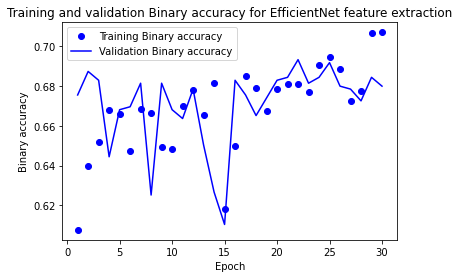

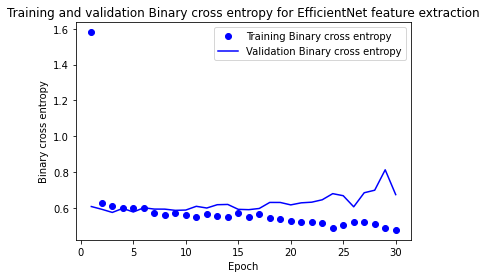

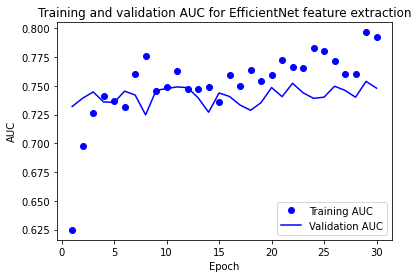

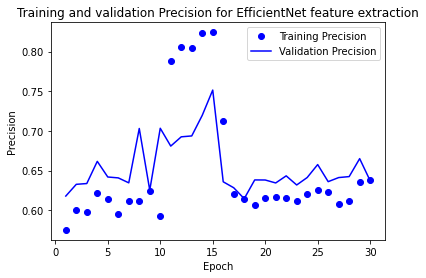

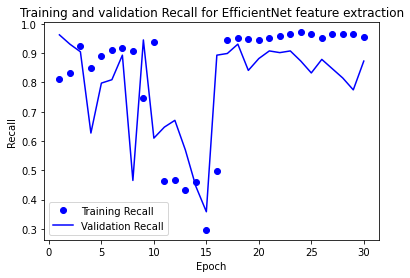

In [72]:
def zipMetricKeysNames(keys, metricNames):
    metricKeys = list(keys)
    metricKeysTrainingOnly = metricKeys[1:len(metricKeys) // 2] # Ignores the generic loss metric and truncates all validation histories
    assert(len(metricNames) == len(metricKeysTrainingOnly))
    zippedMetrics = zip(metricKeysTrainingOnly, metricNames)
    return zippedMetrics

def plotTrainingHistories(history, metricKeysNamesZip, modelName:str):
    for (key, name) in metricKeysNamesZip:
        metricHistory = history.history[key]
        metricValHistory = history.history[f'val_{key}']
        plotOneTrainingHistory(metricHistory, metricValHistory, name, modelName)

def plotOneTrainingHistory(metricHistory, metricValHistory, metricName, modelName):
    plt.figure()
    epochs = range(1, len(metricHistory) + 1)
    plt.plot(epochs, metricHistory, 'bo', label=f'Training {metricName}')
    plt.plot(epochs, metricValHistory, 'b', label=f'Validation {metricName}')
    plt.xlabel('Epoch')
    plt.ylabel(metricName)
    plt.title(f'Training and validation {metricName} for {modelName}')
    plt.legend()
    shortModelName = shortenModelOrMetricName(modelName)
    shortMetricName = shortenModelOrMetricName(metricName)
    plt.savefig(f'{shortModelName}{shortMetricName}.png')

def shortenModelOrMetricName(modelOrMetricName:str):
    return modelOrMetricName.title().replace(' ','')
    
metricsKeysNamesZip = zipMetricKeysNames(efficientNetB0FEClassifierHistory.history.keys(), metricNames)
plotTrainingHistories(efficientNetB0FEClassifierHistory, metricsKeysNamesZip, 'EfficientNet feature extraction')
plt.show()